In [1]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 137.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 23.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller

# Import the correct ARIMA class
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# MSE AND RMSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [4]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder
# os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
os.chdir('/content/gdrive/My Drive/Proj5005/data_preprocessed')
!ls

Mounted at /content/gdrive
 2324_byhour_bylocation.csv
 byborough.ipynb
'Demand2023-2024(byhour)'
'Demand2023-2024(byhour-bypickuplocation)'
'Demand2023-2024(hour-location-mile quantile)'
 demand_hourly_peak.csv
 Demand_time_borough
 Impute_missing_valuies.ipynb
 NYC_Holidays_23_24.csv
'Other Vairable2023-2024(hour-location-mile quantile)'
'Other Variable2023-2024(byhour-bypickuplocation)'
'Other Variable2023-2024(byhour)-General'
 taxi_zone_lookup.csv


In [5]:
df2023 = pd.read_csv('Demand2023-2024(byhour-bypickuplocation)/order_counts_byhour_PULocationID2023.csv')
df2024 = pd.read_csv('Demand2023-2024(byhour-bypickuplocation)/order_counts_byhour_PULocationID2024.csv')

In [6]:
merged_df = pd.concat([df2023, df2024], ignore_index=True)

In [7]:
merged_df

,datetime_hour,PULocationID,order_count
0,2023-01-01 00:00:00,2,1
1,2023-01-01 00:00:00,3,59
2,2023-01-01 00:00:00,4,190
3,2023-01-01 00:00:00,5,21
4,2023-01-01 00:00:00,6,11
...,...,...,...
4421834,2024-12-31 23:00:00,260,247
4421835,2024-12-31 23:00:00,261,111
4421836,2024-12-31 23:00:00,262,109
4421837,2024-12-31 23:00:00,263,255


In [8]:
order_sum_by_loc = merged_df.groupby('PULocationID')['order_count'].sum().sort_values(ascending=False)
print("Top 10 Zones by Total Ride Count:")
print(order_sum_by_loc.head(10))

Top 10 Zones by Total Ride Count:
PULocationID
138    9113542
132    8729054
79     6476941
61     6172485
230    5855430
161    5717682
231    5474438
68     5386163
246    5169061
164    5123424
Name: order_count, dtype: int64


In [9]:
top_loc_id = order_sum_by_loc.index[0]
print(f"Top Location: {top_loc_id}")

Top Location: 138


In [10]:
top_loc_df = merged_df[merged_df['PULocationID'] == top_loc_id]

In [11]:
top_loc_df

,datetime_hour,PULocationID,order_count
131,2023-01-01 00:00:00,138,82
386,2023-01-01 01:00:00,138,45
642,2023-01-01 02:00:00,138,16
896,2023-01-01 03:00:00,138,2
1148,2023-01-01 04:00:00,138,11
...,...,...,...
4420698,2024-12-31 19:00:00,138,341
4420953,2024-12-31 20:00:00,138,194
4421206,2024-12-31 21:00:00,138,376
4421461,2024-12-31 22:00:00,138,212


In [12]:
top_loc_df['datetime_hour'] = pd.to_datetime(top_loc_df['datetime_hour'])

<ipython-input-12-4d23c1fbfcf9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_loc_df['datetime_hour'] = pd.to_datetime(top_loc_df['datetime_hour'])


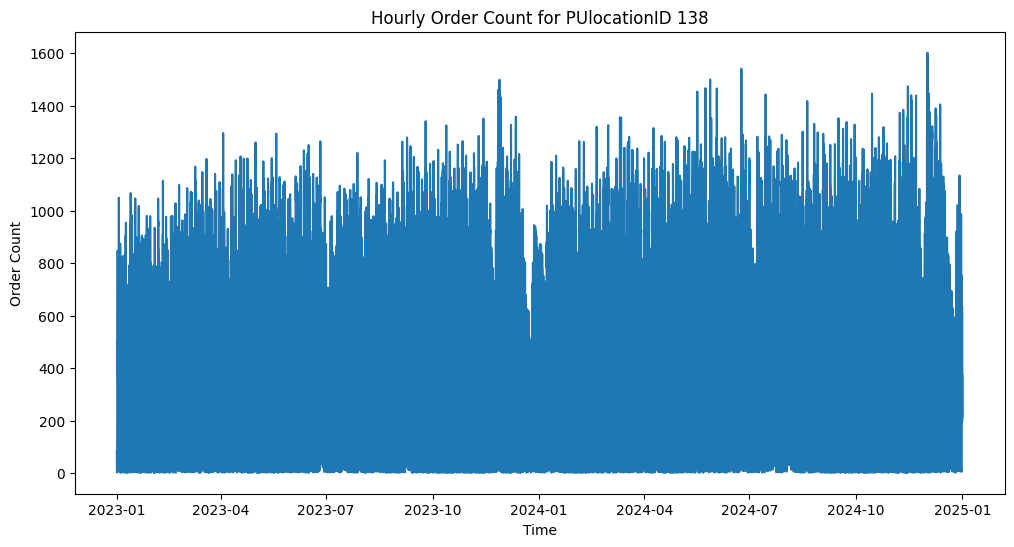

In [13]:
plt.figure(figsize=(12,6))
plt.plot(top_loc_df['datetime_hour'],top_loc_df['order_count'])
plt.title(f"Hourly Order Count for PUlocationID {top_loc_id}")
plt.xlabel("Time")
plt.ylabel("Order Count")
plt.show()

# TESTS

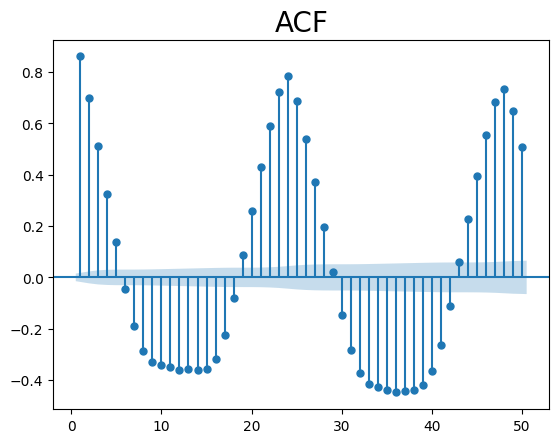

In [15]:
# ACF
sgt.plot_acf(top_loc_df['order_count'], lags=50, alpha=0.05, zero=False)
plt.title("ACF", size=20)
plt.autoscale(enable=True, axis='y')
plt.show()

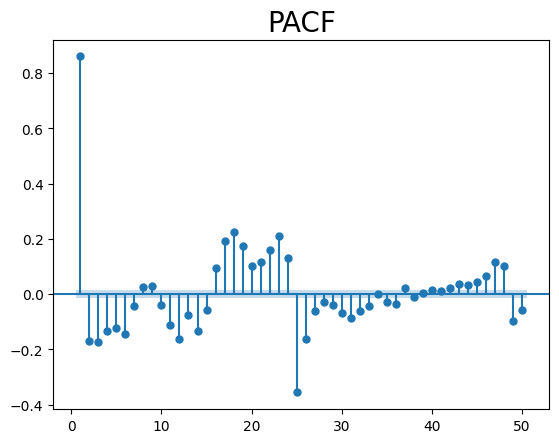

In [16]:
# PCF
sgt.plot_pacf(top_loc_df['order_count'], lags=50, alpha=0.05, zero=False, method = ('ols'))
plt.title("PACF", size=20)
plt.autoscale(enable=True, axis='y')
plt.show()

In [14]:
#Stationarity
from statsmodels.tsa.stattools import adfuller
stationarity = adfuller(top_loc_df['order_count'])
print(f"Augmented Dickey Fuller p-value: {stationarity[1]}")

Augmented Dickey Fuller p-value: 3.0607545029887655e-30


In [35]:
# Seasonal differencing: subtract value from its value 24 steps ago
seasonal_diff = top_loc_df['order_count'] - top_loc_df['order_count'].shift(24)
# Drop NaNs caused by shifting
seasonal_diff = seasonal_diff.dropna()
# Apply ADF test to the seasonally differenced data
stationarity_24 = adfuller(seasonal_diff)
print(f"Augmented Dickey Fuller p-value: {stationarity_24[1]}")

Augmented Dickey Fuller p-value: 0.0


# Exogenous Variables


In [16]:
# Create exogenous variables
top_loc_df['datetime_hour'] = pd.to_datetime(top_loc_df['datetime_hour'])

<ipython-input-16-dee7b9604875>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_loc_df['datetime_hour'] = pd.to_datetime(top_loc_df['datetime_hour'])


In [17]:
top_loc_df['hour'] = top_loc_df['datetime_hour'].dt.hour                # Hour of day (0–23)
top_loc_df['dayofweek'] = top_loc_df['datetime_hour'].dt.dayofweek      # Day of week (0=Mon, 6=Sun)
top_loc_df['is_weekend'] = top_loc_df['dayofweek'].isin([5, 6]).astype(int)
top_loc_df['month'] = top_loc_df['datetime_hour'].dt.month              # Month
top_loc_df['day'] = top_loc_df['datetime_hour'].dt.day                  # Day of month

<ipython-input-17-255643c3d94f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_loc_df['hour'] = top_loc_df['datetime_hour'].dt.hour                # Hour of day (0–23)
<ipython-input-17-255643c3d94f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_loc_df['dayofweek'] = top_loc_df['datetime_hour'].dt.dayofweek      # Day of week (0=Mon, 6=Sun)
<ipython-input-17-255643c3d94f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [18]:
df_hol = pd.read_csv("NYC_Holidays_23_24.csv")
df_hol['Holidays'] = pd.to_datetime(df_hol['Holidays'])
top_loc_df['date'] = top_loc_df['datetime_hour'].dt.date
top_loc_df['is_holiday'] = top_loc_df['date'].isin(df_hol['Holidays']).astype(int)

<ipython-input-18-3564f4bbb06a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_hol['Holidays'] = pd.to_datetime(df_hol['Holidays'])
<ipython-input-18-3564f4bbb06a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_loc_df['date'] = top_loc_df['datetime_hour'].dt.date
<ipython-input-18-3564f4bbb06a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_loc_df['is_h

In [19]:
exog = top_loc_df.drop(columns=['order_count','datetime_hour','date','PULocationID'])  # drop target

In [41]:
exog

,hour,dayofweek,is_weekend,month,day,is_holiday
0,0,6,1,1,1,0
1,1,6,1,1,1,0
2,2,6,1,1,1,0
3,3,6,1,1,1,0
4,4,6,1,1,1,0
...,...,...,...,...,...,...
17479,19,1,0,12,31,0
17480,20,1,0,12,31,0
17481,21,1,0,12,31,0
17482,22,1,0,12,31,0


In [20]:
top_loc_df.reset_index(drop=True, inplace=True)
exog.reset_index(drop=True, inplace=True)

# Train Test Split


In [21]:
train_size = int(len(top_loc_df) * 0.8)
train_set, test_set = top_loc_df[:train_size], top_loc_df[train_size:]

exog_train_set = exog[:train_size]
exog_test_set = exog[train_size:]

# Not needed

In [45]:
model_ar = ARIMA(train_set['order_count'], order = (2,0,0))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            order_count   No. Observations:                13987
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -92627.711
Date:                Thu, 01 May 2025   AIC                         185263.423
Time:                        06:27:23   BIC                         185293.606
Sample:                             0   HQIC                        185273.472
                              - 13987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        512.2448     11.256     45.507      0.000     490.183     534.307
ar.L1          1.0054      0.008    124.319      0.000       0.990       1.021
ar.L2         -0.1687      0.007    -23.849      0.000      -0.183      -0.155
sigma2      3.309e+04    327.579    101.002      0.000    3.24e+04    3.37e+04
===================================================================================
Ljung-Box (L1) (Q):                  11.25   Jarque-Bera (JB):              4812.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
model_ar = ARIMA(train_set['order_count'], order = (2,0,2))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            order_count   No. Observations:                13987
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -92031.846
Date:                Thu, 01 May 2025   AIC                         184075.692
Time:                        06:31:33   BIC                         184120.968
Sample:                             0   HQIC                        184090.766
                              - 13987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        512.2495      5.187     98.751      0.000     502.083     522.416
ar.L1          1.7745      0.010    176.415      0.000       1.755       1.794
ar.L2         -0.8461      0.009    -97.121      0.000      -0.863      -0.829
ma.L1         -0.8689      0.012    -73.937      0.000      -0.892      -0.846
ma.L2          0.0713      0.010      7.252      0.000       0.052       0.091
sigma2      3.038e+04    297.602    102.089      0.000    2.98e+04     3.1e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              2991.64
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SARIMA

In [42]:
model_sa = SARIMAX(train_set['order_count'],
                order=(1,0,1),
                seasonal_order=(1,1,1,24))
modelsa_fit = model_sa.fit()
print(modelsa_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        order_count   No. Observations:                13987
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -88358.160
Date:                            Thu, 01 May 2025   AIC                         176726.321
Time:                                    13:25:59   BIC                         176764.042
Sample:                                         0   HQIC                        176738.880
                                          - 13987                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8194      0.005    151.183      0.000       0.809       0.830
ma.L1         -0.2231      0.009   

# SARIMAX

In [23]:
exog_train_set_drop = exog_train_set.drop(columns=['is_holiday','month'])

In [43]:
model_sax = SARIMAX(train_set['order_count'],
                exog=exog_train_set_drop,
                order=(1,0,1),
                seasonal_order=(1,1,1,24))
modelsax_fit = model_sax.fit()
print(modelsax_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                        order_count   No. Observations:                13987
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -88172.176
Date:                            Thu, 01 May 2025   AIC                         176362.352
Time:                                    13:29:43   BIC                         176430.249
Sample:                                         0   HQIC                        176384.959
                                          - 13987                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour          13.4225      0.263     51.103      0.000      12.908      13.937
dayofweek     28.6315      1.574   

# BenchMark

In [25]:
test_set['order_count_benchmark'] = test_set['order_count'].shift(1)
test_set.loc[test_set.index[0], 'order_count_benchmark'] = train_set['order_count'].iloc[-1]

<ipython-input-25-201252ee4897>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['order_count_benchmark'] = test_set['order_count'].shift(1)


# PLOTS

In [26]:
test_all = test_set.shape[0]

In [31]:
train_plots = 120 # 5 Days
test_plots = 720 # 30 Days

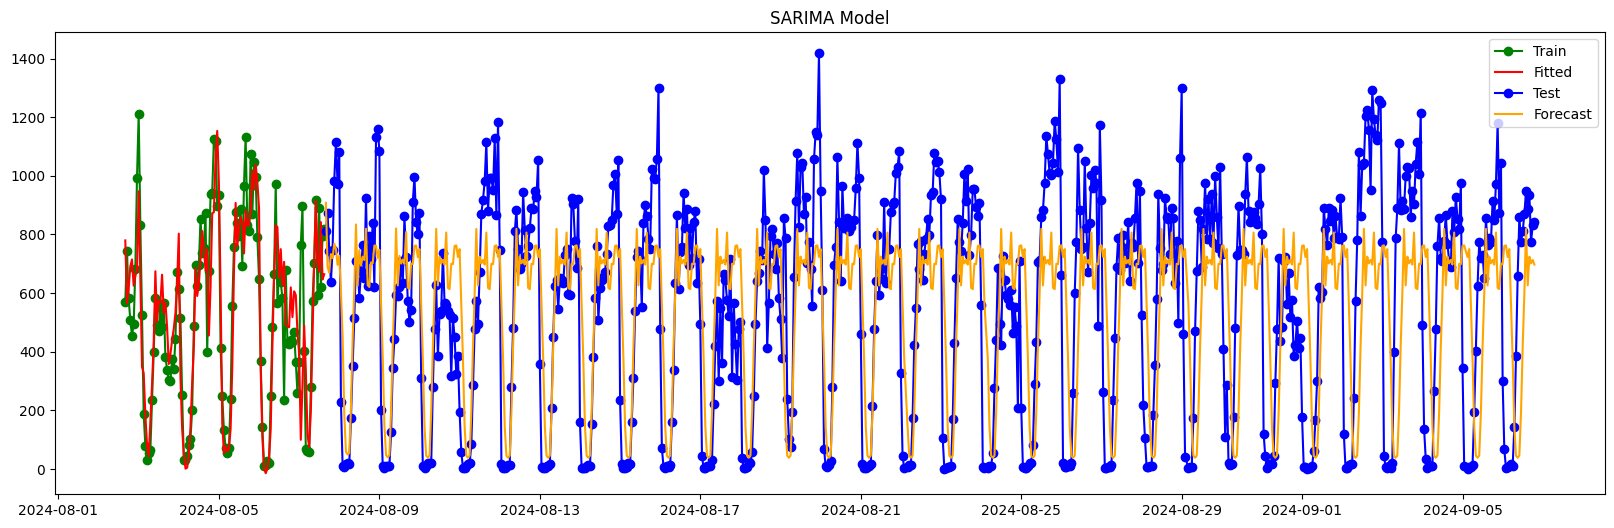

MSE: 261097.89858252357
RMSE: 510.9773953733409


In [46]:
#SARIMA

plt.figure(figsize=(20, 6))
plt.plot(train_set['datetime_hour'].tail(train_plots), train_set['order_count'].tail(train_plots), label="Train", marker='o', color='green')
plt.plot(train_set['datetime_hour'].tail(train_plots), modelsa_fit.fittedvalues.tail(train_plots), label="Fitted", color='red')
plt.plot(test_set['datetime_hour'].head(test_plots), test_set['order_count'].head(test_plots), color='blue', label="Test", marker='o')
plt.plot(test_set['datetime_hour'].head(test_plots), modelsa_fit.forecast(steps=test_plots), color='orange', label="Forecast")
plt.title("SARIMA Model") # Use plt.title as a function to set the title
plt.legend()
plt.show()

#MSE AND RMSE
mse = mean_squared_error(test_set['order_count'], modelsa_fit.forecast(steps=test_all))
rmse = root_mean_squared_error(test_set['order_count'], modelsa_fit.forecast(steps=test_all))
print("MSE:", mse)
print("RMSE:", rmse)

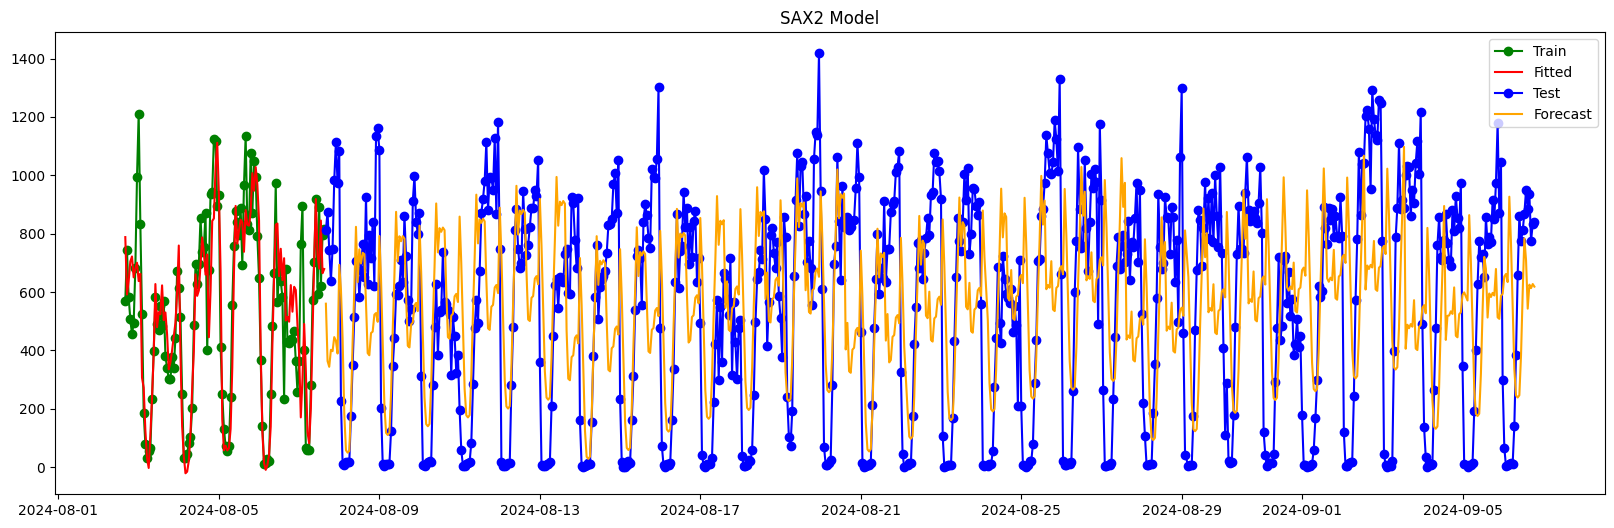

MSE: 254501.57879400367
RMSE: 504.4814949965991


In [47]:
#SARIMAX

plt.figure(figsize=(20, 6))
plt.plot(train_set['datetime_hour'].tail(train_plots), train_set['order_count'].tail(train_plots), label="Train", marker='o', color='green')
plt.plot(train_set['datetime_hour'].tail(train_plots), modelsax_fit.fittedvalues.tail(train_plots), label="Fitted", color='red')
plt.plot(test_set['datetime_hour'].head(test_plots), test_set['order_count'].head(test_plots), color='blue', label="Test", marker='o')
plt.plot(test_set['datetime_hour'].head(test_plots), modelsax_fit.forecast(steps=test_plots,exog=exog_train_set_drop.head(test_plots)), color='orange', label="Forecast")
plt.title("SAX2 Model")
plt.legend()
plt.show()

#MSE AND RMSE
mse = mean_squared_error(test_set['order_count'], modelsax_fit.forecast(steps=test_all,exog=exog_train_set_drop.head(test_all)))
rmse = root_mean_squared_error(test_set['order_count'], modelsax_fit.forecast(steps=test_all,exog=exog_train_set_drop.head(test_all)))
print("MSE:", mse)
print("RMSE:", rmse)

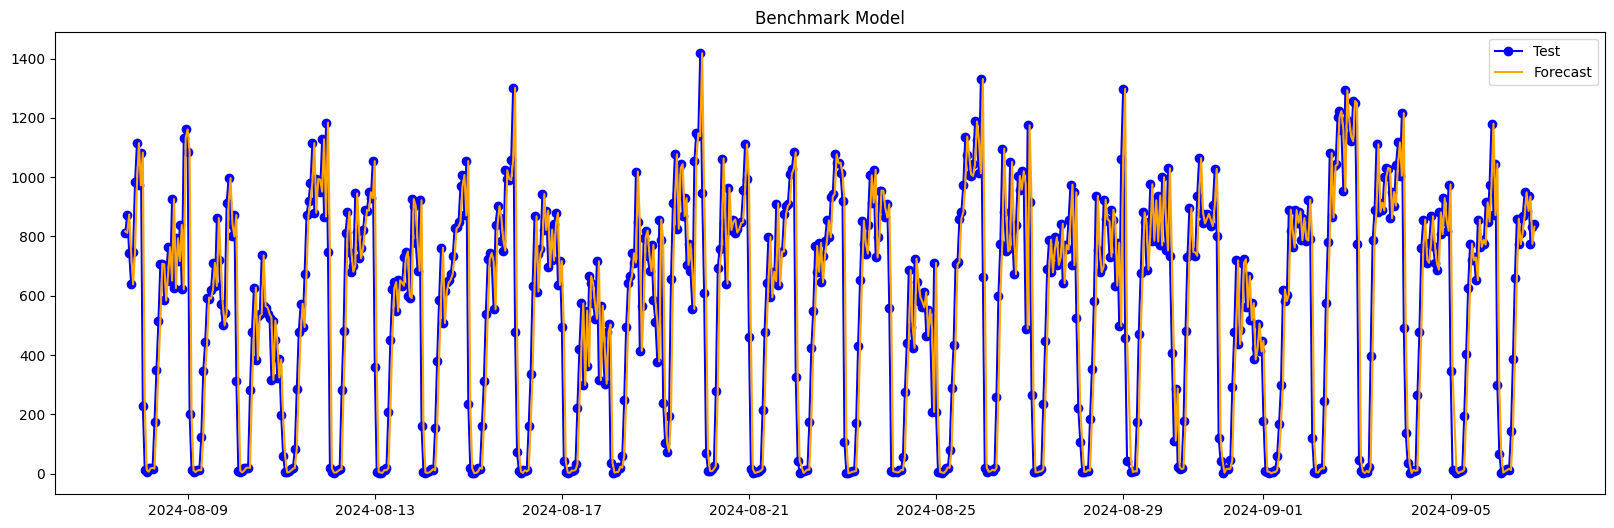

MSE: 44245.25850729196
RMSE: 210.34556925994892


In [34]:
#BENCHMARK

plt.figure(figsize=(20, 6))
#plt.plot(train_set.tail(train_plots).index, train_set['order_count'].tail(train_plots), label="Train", marker='o', color='green')
#plt.plot(train_set.tail(train_plots).index, modelsax2_fit.fittedvalues.tail(train_plots), label="Fitted", color='red')
plt.plot(test_set['datetime_hour'].head(test_plots), test_set['order_count'].head(test_plots), color='blue', label="Test", marker='o')
plt.plot(test_set['datetime_hour'].head(test_plots), test_set['order_count_benchmark'].head(test_plots), color='orange', label="Forecast")
plt.title("Benchmark Model")
plt.legend()
plt.show()

#MSE AND RMSE
mse = mean_squared_error(test_set['order_count'], test_set['order_count_benchmark'])
rmse = root_mean_squared_error(test_set['order_count'], test_set['order_count_benchmark'])
print("MSE:", mse)
print("RMSE:", rmse)